# Le PIB est-il un indicateur robuste de l'accès à l'alimentation ?

In [136]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Partie 1 : Collecte des données

### Récupération des données de PIB à partir de la base de données de la banque mondiale

In [4]:
url = "https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.KD?format=json&per_page=20000"


response = requests.get(url)

# Extraction du JSON de la réponse
PIB_hab = response.json()  # ici c’est correct

# Vérification des données
print(type(PIB_hab),len(PIB_hab))
print(PIB_hab[0]) # Métadonnées
print(PIB_hab[1][:5]) # Données de PIB par pays


<class 'list'> 2
{'page': 1, 'pages': 1, 'per_page': 20000, 'total': 17290, 'sourceid': '2', 'lastupdated': '2025-12-04'}
[{'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2024', 'value': 1416.25036869408, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2023', 'value': 1412.62538438423, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2022', 'value': 1421.79716897878, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 

#Retraitement des données


Suppression des colonnes inutiles

In [44]:
donnees = PIB_hab[1]  # On ne garde pas les métadonnées

# On transforme le JSON en DataFrame et on ne garde que le PIB/hab pour chaque années avec le nom et le code du pays
liste_simplifiee = []
for item in donnees:
    nom_pays = item['country']['value']  # nom complet du pays
    annee = int(item['date'])
    pib = item['value']
    liste_simplifiee.append({'nom_pays': nom_pays, 'année': annee, 'PIB_par_habitant': pib})

PIB_hab_simple = pd.DataFrame(liste_simplifiee)

# Filtrer uniquement les années de 1960 à 2022. 
PIB_hab_simple = PIB_hab_simple[(PIB_hab_simple['année'] >= 2000) & (PIB_hab_simple['année'] <= 2024)]

# Afficher les 5 premières lignes
print(PIB_hab_simple.head(200))
PIB_hab_simple.loc[PIB_hab_simple['nom_pays'] == 'Russia']

                                        nom_pays  année  PIB_par_habitant
0                    Africa Eastern and Southern   2024       1416.250369
1                    Africa Eastern and Southern   2023       1412.625384
2                    Africa Eastern and Southern   2022       1421.797169
3                    Africa Eastern and Southern   2021       1409.040699
4                    Africa Eastern and Southern   2020       1383.724119
..                                           ...    ...               ...
475  East Asia & Pacific (excluding high income)   2004       2835.250834
476  East Asia & Pacific (excluding high income)   2003       2618.816094
477  East Asia & Pacific (excluding high income)   2002       2422.476717
478  East Asia & Pacific (excluding high income)   2001       2259.818286
479  East Asia & Pacific (excluding high income)   2000       2132.394104

[200 rows x 3 columns]


,nom_pays,année,PIB_par_habitant


Filtrage pour enlever les pays contenant des valeurs manquantes

In [6]:
#PIB_hab_simple_sans_NA = PIB_hab_simple.dropna()
#print(len(PIB_hab_simple['nom_pays'])/(2022-1960+1),len(PIB_hab_simple_sans_NA['nom_pays'])//(2022-1960+1)) # On a enlevé 48 pays ou groupe de pays de la liste

Restriction aux pays suivants : France, Etats-unis, Angleterre, Russie, Chine, Japon, Brésil, Afrique du Sud

In [45]:
# Liste des pays à conserver
pays_a_conserver = [
    'India', 'China', 'Brazil', 'South Africa', 'Russian Federation', 'Mexico'
]

# Filtrer le DataFrame
PIB_hab_BRICSAM = PIB_hab_simple[PIB_hab_simple['nom_pays'].isin(pays_a_conserver)]

# Vérifier le résultat
print(PIB_hab_BRICSAM['nom_pays'].unique())
print(PIB_hab_BRICSAM.head(126))

['Brazil' 'China' 'India' 'Mexico' 'Russian Federation' 'South Africa']
                 nom_pays  année  PIB_par_habitant
4875               Brazil   2024       9564.576077
4876               Brazil   2023       9288.027015
4877               Brazil   2022       9032.084816
4878               Brazil   2021       8799.229458
4879               Brazil   2020       8435.011433
...                   ...    ...               ...
13671  Russian Federation   2003       6370.453613
13672  Russian Federation   2002       5910.171875
13673  Russian Federation   2001       5618.955566
13674  Russian Federation   2000       5323.666504
14690        South Africa   2024       5708.964422

[126 rows x 3 columns]


Gestion des valeurs manquantes

In [46]:
for pays in PIB_hab_BRICSAM['nom_pays'].unique() :
    print(PIB_hab_BRICSAM.loc[PIB_hab_BRICSAM['nom_pays'] == pays].isna().sum(),pays)

nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 Brazil
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 China
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 India
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 Mexico
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 Russian Federation
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 South Africa


### Récupération des données indicateurs alimentaires à partir de la base de données FAOSTAT

In [14]:
pip install faostat

Note: you may need to restart the kernel to use updated packages.


In [15]:
import faostat
df = faostat.list_datasets_df()
list = []
for i in range(67):
    list.append(df.iloc[i,0:2])
    print(list[i])


code                              QCL
label    Crops and livestock products
Name: 0, dtype: object
code                     QI
label    Production Indices
Name: 1, dtype: object
code                                   QV
label    Value of Agricultural Production
Name: 2, dtype: object
code                                    FS
label    Suite of Food Security Indicators
Name: 3, dtype: object
code                       FBS
label    Food Balances (2010-)
Name: 4, dtype: object
code                                     SCL
label    Supply Utilization Accounts (2010-)
Name: 5, dtype: object
code                                        CB
label    Commodity Balances (non-food) (2010-)
Name: 6, dtype: object
code                                                  FBSH
label    Food Balances (-2013, old methodology and popu...
Name: 7, dtype: object
code                                                   CBH
label    Commodity Balances (non-food) (-2013, old meth...
Name: 8, dtype: object
code     

In [113]:
#print(faostat.list_pars_df('FS'))
#print(np.sort(faostat.get_par_df('FS', 'countries')))
#print(faostat.get_par_df('FS', 'year3'))
#print(faostat.get_par_df('FS', 'element'))
print(faostat.get_par_df('FS', 'item'))
#print(faostat.get_par_df('FS', 'area'))

                                                label    code aggregate_type
0                        Featured Indicators > (List)  21054>              >
1         -- Prevalence of undernourishment (percent)   21004              0
2        -- Number of people undernourished (million)   21001              0
3   -- Prevalence of severe food insecurity in the...   21040              0
4   -- Prevalence of moderate or severe food insec...   21009              0
5   -- Number of severely food insecure people (mi...   21007              0
6   -- Number of moderately or severely food insec...   21008              0
7   -- Percentage of children under 5 years affect...   21026              0
8   -- Number of children under 5 years affected b...  210260              0
9   -- Percentage of children under 5 years of age...   21025              0
10  -- Number of children under 5 years of age who...  210250              0
11  -- Percentage of children under 5 years of age...   21041              0

On souhaite récupérer les indicateurs suivants : {
    21010: "suffisance des apports énergétiques alimentaires moyens",
    22000: "disponibilité alimentaire par habitant",
    21013: "disponibilité protéiques moyenne",
    210104: "disponibilité protéines moyennes animales",
    22013: "PIB/ HAB",
    210041: "prévalence de la sous alimentation",
    210401: "prévalence de l'insécurité alimentaire grave",
    210091: "prévalence de l'insécurité alimentaire modérée ou grave",
    21031: "variabilité des disponibilités alimentaires"
}

In [128]:
liste_pays = [202,185,138,100,351,21] # dans l'ordre : Brazil, ...

mypars = {'area': liste_pays,
              'element': [6120],
              'item': ['21010','22000','21013','21004'],
              'year': [2000, 2022]}
data_faostat = faostat.get_data_df('FS', pars=mypars, strval=False)
print(data_faostat.head(100))
print(data_faostat['Item Code'].unique())


   Domain Code                             Domain  Area Code    Area  \
0           FS  Suite of Food Security Indicators         21  Brazil   
1           FS  Suite of Food Security Indicators         21  Brazil   
2           FS  Suite of Food Security Indicators         21  Brazil   
3           FS  Suite of Food Security Indicators         21  Brazil   
4           FS  Suite of Food Security Indicators         21  Brazil   
..         ...                                ...        ...     ...   
95          FS  Suite of Food Security Indicators        351   China   
96          FS  Suite of Food Security Indicators        351   China   
97          FS  Suite of Food Security Indicators        351   China   
98          FS  Suite of Food Security Indicators        351   China   
99          FS  Suite of Food Security Indicators        351   China   

    Element Code Element  Item Code  \
0           6121   Value      21010   
1           6121   Value      21010   
2           6121  

On nettoie la base

In [129]:
data_faostat = data_faostat.drop(['Domain Code', 'Domain', 'Area Code', 'Element Code', 'Element', 'Year Code'], axis=1)
data_faostat = data_faostat.rename(columns={'Item': 'Indicateur'})
print(data_faostat.head(100))
print(data_faostat.isna().sum())
print(data_faostat['Item Code'].unique())
data_faostat.head()

      Area  Item Code                                         Indicateur  \
0   Brazil      21010  Average dietary energy supply adequacy (percen...   
1   Brazil      21010  Average dietary energy supply adequacy (percen...   
2   Brazil      21010  Average dietary energy supply adequacy (percen...   
3   Brazil      21010  Average dietary energy supply adequacy (percen...   
4   Brazil      21010  Average dietary energy supply adequacy (percen...   
..     ...        ...                                                ...   
95   China      21010  Average dietary energy supply adequacy (percen...   
96   China      21010  Average dietary energy supply adequacy (percen...   
97   China      21010  Average dietary energy supply adequacy (percen...   
98   China      21010  Average dietary energy supply adequacy (percen...   
99   China      21010  Average dietary energy supply adequacy (percen...   

         Year Unit Value  
0   2000-2002    %   122  
1   2001-2003    %   124  
2   20

,Area,Item Code,Indicateur,Year,Unit,Value
0,Brazil,21010,Average dietary energy supply adequacy (percen...,2000-2002,%,122
1,Brazil,21010,Average dietary energy supply adequacy (percen...,2001-2003,%,124
2,Brazil,21010,Average dietary energy supply adequacy (percen...,2002-2004,%,127
3,Brazil,21010,Average dietary energy supply adequacy (percen...,2003-2005,%,129
4,Brazil,21010,Average dietary energy supply adequacy (percen...,2004-2006,%,130


Passage des données sur 3 ans

In [130]:
print(data_faostat.loc[(data_faostat['Year'] == '2016-2018') &
                        (data_faostat['Area'] == 'Brazil')])


      Area  Item Code                                         Indicateur  \
16  Brazil      21010  Average dietary energy supply adequacy (percen...   
39  Brazil      22000  Dietary energy supply used in the estimation o...   
62  Brazil      21013  Average protein supply (g/cap/day) (3-year ave...   
83  Brazil     210041  Prevalence of undernourishment (percent) (3-ye...   

         Year        Unit Value  
16  2016-2018           %   135  
39  2016-2018  kcal/cap/d  3306  
62  2016-2018     g/cap/d   103  
83  2016-2018           %  <2.5  


Passage des données par années

In [131]:
for year in data_faostat['Year'].unique():
    # Tronquer la valeur de 'Year' à 4 caractères
    data_faostat.loc[data_faostat['Year'] == year, 'Year'] = year[:4]

# Afficher le résultat
print(data_faostat.head())

     Area  Item Code                                         Indicateur  Year  \
0  Brazil      21010  Average dietary energy supply adequacy (percen...  2000   
1  Brazil      21010  Average dietary energy supply adequacy (percen...  2001   
2  Brazil      21010  Average dietary energy supply adequacy (percen...  2002   
3  Brazil      21010  Average dietary energy supply adequacy (percen...  2003   
4  Brazil      21010  Average dietary energy supply adequacy (percen...  2004   

  Unit Value  
0    %   122  
1    %   124  
2    %   127  
3    %   129  
4    %   130  


## Partie 2 : DATA VISUALIZATION

Evolutions des PIB/HAB

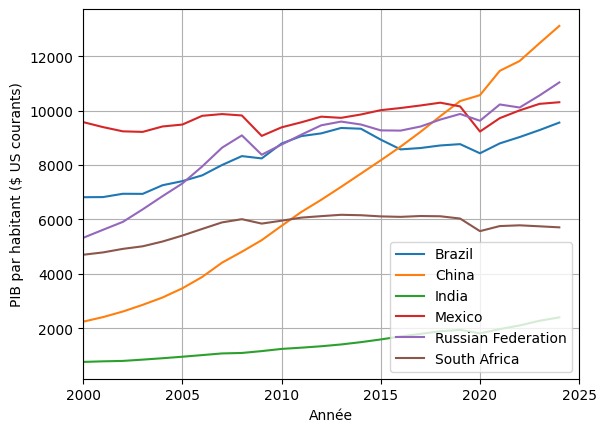

In [143]:
for pays in PIB_hab_BRICSAM['nom_pays'].unique() :
    PIB_hab_pays=PIB_hab_BRICSAM.loc[PIB_hab_BRICSAM['nom_pays'] == pays]
    plt.plot(PIB_hab_pays['année'],PIB_hab_pays['PIB_par_habitant'],label=pays)

plt.xlabel('Année')    
plt.ylabel('PIB par habitant ($ US courants)')
plt.grid()
plt.legend()
plt.xlim(left=2000, right=2025)
plt.show()

Illustrations indicateurs

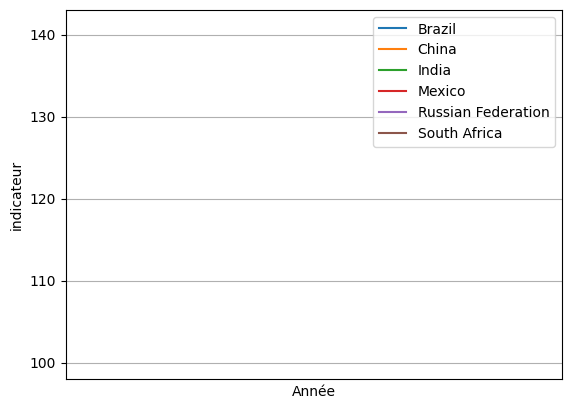

In [160]:
for pays in data_faostat['Area'].unique() :
    data_21010 = data_faostat.loc[data_faostat['Item Code']==21010]
    data_21010_pays = data_21010.loc[data_21010['Area']==pays]
    plt.plot(data_21010_pays['Year'],data_21010_pays['Value'],label=pays)

plt.xlabel('Année')    
plt.ylabel('indicateur')
plt.grid()
plt.legend()
plt.xlim(left=2000, right=2025)
plt.show()

## Partie 3 : MODELE

### ACP

In [13]:

import faostat
import pandas as pd
df = faostat.list_datasets_df()
list = []
for i in range(67):
    list.append(df.iloc[i,0:2])
    print(list[i])
liste_pays = [21,68,100,110,185,229,231,351] # dans l'ordre : Brazil, ...

mypars = {'area': liste_pays,
              'element': [6120],
              'item': ['21010','22000','21013','210104','22013','210401','21031'],
              'year': [1999, 2025]}
data_faostat = faostat.get_data_df('FS', pars=mypars, strval=False)
data_faostat.head(100)
data_faostat = data_faostat.drop(['Domain Code', 'Domain', 'Area Code', 'Element Code', 'Element', 'Year Code', 'Item Code'], axis=1)
data_faostat = data_faostat.rename(columns={'Item': 'Indicateur'})
# Récupérer les noms d’indicateurs correspondant aux codes que tu veux
items_acp = ['21010','22000','21013','210104','210401','21031']

# On repart depuis les données AVANT suppression de 'Item Code'
# Donc recharge les données brutes :
data_faostat_raw = faostat.get_data_df('FS', pars=mypars, strval=False)

# Sélection uniquement des items que tu veux
data_items = data_faostat_raw[data_faostat_raw['Item Code'].astype(str).isin(items_acp)]

# Liste propre des noms d’indicateurs
liste_indicateurs = sorted(data_items['Item'].unique().tolist())
print("Indicateurs sélectionnés :", liste_indicateurs)

# --- Liste des items (codes FAOSTAT) que tu veux dans l'ACP ---
items_acp = ['21010','22000','21013','210104','210401','21031']

data_acp = data_faostat[data_faostat['Indicateur'].isin(liste_indicateurs)]

# Pivot large
df_wide = data_acp.pivot_table(
    index=['Area', 'Year'],
    columns='Indicateur',
    values='Value'
).reset_index()


df_wide_clean = df_wide.fillna(df_wide.mean(numeric_only=True))


# Vérification
print("Colonnes ACP :", df_wide_clean.columns)

# ACP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_wide_clean.iloc[:, 2:]  # variables quantitatives

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=1)
df_wide_clean['Score_ACP'] = pca.fit_transform(X_scaled)

df_wide_clean.head(20)

print("Variance expliquée par PC1 :", pca.explained_variance_ratio_[0])

loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=['PC1']
)
print("\nContributions des variables à PC1 :")
print(loadings)

print("\nScores ACP (PC1) :")
print(df_wide_clean[['Area', 'Year', 'Score_ACP']].head(20))



code                              QCL
label    Crops and livestock products
Name: 0, dtype: object
code                     QI
label    Production Indices
Name: 1, dtype: object
code                                   QV
label    Value of Agricultural Production
Name: 2, dtype: object
code                                    FS
label    Suite of Food Security Indicators
Name: 3, dtype: object
code                       FBS
label    Food Balances (2010-)
Name: 4, dtype: object
code                                     SCL
label    Supply Utilization Accounts (2010-)
Name: 5, dtype: object
code                                        CB
label    Commodity Balances (non-food) (2010-)
Name: 6, dtype: object
code                                                  FBSH
label    Food Balances (-2013, old methodology and popu...
Name: 7, dtype: object
code                                                   CBH
label    Commodity Balances (non-food) (-2013, old meth...
Name: 8, dtype: object
code     

### Régression(s) linéaire PIB/hab

### Régression(s) linéaire IDH